### 1. Importing Needed Libraries and Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
#importing turnstiles' data from the path for month of February through end of July of 2021
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True)) #parse datetime
    return pd.concat(dfs)
        
week_nums = [210206,210213,210220,210227,
             210306,210313,210320,210327,
             210403,210410,210417,210424,
             210501,210508,210515,210522,210529,
             210605,210612,210619,210626,
             210703,210710,210717,210724,210731]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
#eliminating the white space at the end of titles
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [5]:
turnstiles_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-01-30 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,03:00:00,REGULAR,7524539,2564693
1,2021-01-30 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,07:00:00,REGULAR,7524543,2564703
2,2021-01-30 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,11:00:00,REGULAR,7524566,2564755
3,2021-01-30 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,15:00:00,RECOVR AUD,7524643,2564793
4,2021-01-30 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,19:00:00,REGULAR,7524739,2564811


In [6]:
turnstiles_df.shape

(5439809, 12)

In [7]:
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5439809 entries, 0 to 209462
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   DATE_TIME  datetime64[ns]
 1   C/A        object        
 2   UNIT       object        
 3   SCP        object        
 4   STATION    object        
 5   LINENAME   object        
 6   DIVISION   object        
 7   DATE       object        
 8   TIME       object        
 9   DESC       object        
 10  ENTRIES    int64         
 11  EXITS      int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 539.5+ MB


### 2. Data Cleaning

Each combination of C/A, UNIT, SCP, and STATION represents a unique turnstile. So let's look at a single turnstile in a single day:

In [8]:
turnstiles_df[(turnstiles_df["C/A"] == "A002") & 
(turnstiles_df["UNIT"] == "R051") & 
(turnstiles_df["SCP"] == "02-00-00") & 
(turnstiles_df["STATION"] == "59 ST") &
(turnstiles_df["DATE"] == "01/30/2021")]

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-01-30 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,03:00:00,REGULAR,7524539,2564693
1,2021-01-30 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,07:00:00,REGULAR,7524543,2564703
2,2021-01-30 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,11:00:00,REGULAR,7524566,2564755
3,2021-01-30 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,15:00:00,RECOVR AUD,7524643,2564793
4,2021-01-30 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,19:00:00,REGULAR,7524739,2564811
5,2021-01-30 23:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,23:00:00,REGULAR,7524821,2564823


The data for each unique turnstile in a day show the number of entries and exits at approximately every 4 hours!

In [9]:
#let's see how many "RECOVR AUD" entries we have; They refer to a missed audit that was recovered.
turnstiles_df.DESC.value_counts()

REGULAR       5417147
RECOVR AUD      22662
Name: DESC, dtype: int64

### 2.1 Data Cleaning: Handling Duplicates

In [10]:
#Checking to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique by counting ENTRIES
duplicate_entries = (turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
duplicate_entries.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
462819,B024,R211,00-05-00,KINGS HWY,2021-05-05 12:00:00,2
3614497,R138,R293,00-02-00,34 ST-PENN STA,2021-02-28 05:00:00,2
1669263,N100,R252,00-00-00,HIGH ST,2021-03-07 07:00:00,2
1669262,N100,R252,00-00-00,HIGH ST,2021-03-07 03:00:00,2
1669261,N100,R252,00-00-00,HIGH ST,2021-03-06 23:00:00,2


Let's remove the duplicates:

In [11]:
#dropping the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [12]:
turnstiles_df.shape

(5439693, 12)

The rows count dropped from 5,439,809 to 5,439,693! 

In [13]:
#checking for unique counts for Entries and EXITS once more (post eliminating duplicates)
duplicate_entries = (turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
duplicate_entries.head()
#if you check for EXITS as well the final result will be the same!

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-01-30 03:00:00,1
3626469,R138,R293,00-05-00,34 ST-PENN STA,2021-02-09 13:00:00,1
3626467,R138,R293,00-05-00,34 ST-PENN STA,2021-02-09 05:00:00,1
3626466,R138,R293,00-05-00,34 ST-PENN STA,2021-02-09 01:00:00,1
3626465,R138,R293,00-05-00,34 ST-PENN STA,2021-02-08 21:00:00,1


In [14]:
#Let's count the DESC categories once more:
turnstiles_df.DESC.value_counts()

REGULAR       5417147
RECOVR AUD      22546
Name: DESC, dtype: int64

As we can see the number of RECOVR AUD dropped after eliminating the duplicates! Since we don't have any duplicate entries (in both ENTRIES and EXITS columns), the RECOVR AUD observations can be kept! I'm just going to drop the DESC column since we won't be needing it anymore!

In [15]:
# Drop Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["DESC"], axis=1, errors="ignore")

In [16]:
turnstiles_df.shape

(5439693, 11)

### 2.2 Data Cleaning: Defining Coffee Hour Dataframe

In this analysis, we are interested in data for hours between 8AM and 5PM! We really don't need to carry the extra data around! Let's create a new dataframe and call it coffee_hour:

In [17]:
turnstiles_df = turnstiles_df.set_index(['DATE_TIME']) #index must be datatime index for .between_time method
coffee_hour = turnstiles_df.between_time('08:00:00', '17:00:00')
coffee_hour.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS
DATE_TIME,,,,,,,,,,
2021-07-30 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,17:00:00,5554,590
2021-07-30 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,13:00:00,5554,589
2021-07-30 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,09:00:00,5554,589
2021-07-29 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/29/2021,17:00:00,5554,589
2021-07-29 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/29/2021,13:00:00,5554,589


In [18]:
coffee_hour.shape

(2541098, 10)

In [19]:
coffee_hour.describe()

,ENTRIES,EXITS
count,2.541098e+06,2.541098e+06
mean,4.236840e+07,3.386924e+07
std,2.195915e+08,1.939291e+08
min,0.000000e+00,0.000000e+00
25%,2.372715e+05,1.003482e+05
50%,1.496974e+06,9.035665e+05
75%,6.161610e+06,4.062458e+06
max,2.147432e+09,2.123039e+09


Lets's look at daily entries at each turnstiles! Since our entries(and also exits) counts are accumulating through the day, we need to find the max:

In [20]:
#counting the max ENTRIES using .first()
coffee_hour_daily_entries = (coffee_hour.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.first())
coffee_hour_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/30/2021,7524643
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790


In [21]:
#counting the max EXITS using .first()
coffee_hour_daily_exits = (coffee_hour.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).EXITS.first())
coffee_hour_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,01/30/2021,2564793
1,A002,R051,02-00-00,59 ST,01/31/2021,2564880
2,A002,R051,02-00-00,59 ST,02/01/2021,2565011
3,A002,R051,02-00-00,59 ST,02/02/2021,2565165
4,A002,R051,02-00-00,59 ST,02/03/2021,2565430


In [22]:
#creating 'PREV_DATE' and 'PREV_ENTRIES' columns
coffee_hour_daily_entries[["PREV_DATE", "PREV_ENTRIES"]] = (coffee_hour_daily_entries
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .apply(lambda grp: grp.shift(1)))
#creating 'PREV_DATE' and 'PREV_EXITS' columns
coffee_hour_daily_exits[["PREV_DATE", "PREV_EXITS"]] = (coffee_hour_daily_exits
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "EXITS"]]
                                                       .apply(lambda grp: grp.shift(1)))

In [23]:
#merge two dataframes
coffee_hour_daily = pd.merge(coffee_hour_daily_entries, coffee_hour_daily_exits,
                             on = ["C/A", "UNIT", "SCP", "STATION", "DATE", "PREV_DATE"])
coffee_hour_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,EXITS,PREV_EXITS
0,A002,R051,02-00-00,59 ST,01/30/2021,7524643,NaN,NaN,2564793,NaN
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927,01/30/2021,7524643.0,2564880,2564793.0
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206,01/31/2021,7524927.0,2565011,2564880.0
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362,02/01/2021,7525206.0,2565165,2565011.0
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790,02/02/2021,7525362.0,2565430,2565165.0


In [24]:
#Dropping the rows for the earliest date in the df
coffee_hour_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [25]:
coffee_hour_daily.shape

(903332, 10)

### 2.3 Data Cleaning: Reverse Entries or Exits Counts

In [26]:
#Let's see if we have any reverse counts for ENTRIES
coffee_hour_daily[coffee_hour_daily["ENTRIES"] < coffee_hour_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,EXITS,PREV_EXITS
779,A002,R051,02-03-02,59 ST,03/22/2021,22,03/21/2021,6641312.0,8,8869406.0
7095,A011,R080,01-03-00,57 ST-7 AV,01/31/2021,885624093,01/30/2021,885624214.0,489679349,489679817.0
7096,A011,R080,01-03-00,57 ST-7 AV,02/01/2021,885623972,01/31/2021,885624093.0,489678928,489679349.0
7097,A011,R080,01-03-00,57 ST-7 AV,02/02/2021,885623879,02/01/2021,885623972.0,489678499,489678928.0
7098,A011,R080,01-03-00,57 ST-7 AV,02/03/2021,885623697,02/02/2021,885623879.0,489677728,489678499.0


Let's check one of the above dates to see what's the deal with the reverse counts?

In [27]:
# What's the deal with counter being in reverse
# Checking the specific turnstile on 3/21/2021
mask = ((coffee_hour["C/A"] == "A002") & 
(coffee_hour["UNIT"] == "R051") & 
(coffee_hour["SCP"] == "02-03-02") & 
(coffee_hour["STATION"] == "59 ST") &
(coffee_hour["DATE"] == '03/21/2021'))
coffee_hour[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS
DATE_TIME,,,,,,,,,,
2021-03-21 16:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/21/2021,16:00:00,6641312,8869406
2021-03-21 12:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/21/2021,12:00:00,6641256,8869313
2021-03-21 08:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/21/2021,08:00:00,6641231,8869250


In [28]:
# Checking the specific turnstile on 3/22/2021
mask = ((coffee_hour["C/A"] == "A002") & 
(coffee_hour["UNIT"] == "R051") & 
(coffee_hour["SCP"] == "02-03-02") & 
(coffee_hour["STATION"] == "59 ST") &
(coffee_hour["DATE"] == '03/22/2021'))
coffee_hour[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS
DATE_TIME,,,,,,,,,,
2021-03-22 16:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/22/2021,16:00:00,22,8
2021-03-22 12:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/22/2021,12:00:00,6641481,8869858
2021-03-22 08:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,03/22/2021,08:00:00,6641446,8869630


Looks like there has been a reset on 3/22/2021 at 4PM!

Let's see how many counters have reverse counts:

In [29]:
#How many stations have this problem?

(coffee_hour_daily[coffee_hour_daily["ENTRIES"] < coffee_hour_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A002   R051  02-03-02  59 ST                1
A011   R080  01-03-00  57 ST-7 AV         181
             01-03-03  57 ST-7 AV           1
             01-03-04  57 ST-7 AV           1
A013   R081  01-06-01  49 ST                2
                                         ... 
R622   R123  00-00-00  FRANKLIN AV        180
R624   R124  00-00-02  KINGSTON AV          1
R730   R431  00-00-04  EASTCHSTER/DYRE    180
S101   R070  00-00-04  ST. GEORGE           1
TRAM2  R469  00-05-00  RIT-ROOSEVELT        1
Length: 339, dtype: int64

In [30]:
#Let's deal with the reverse counts:
def get_daily_entries_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > ~1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
coffee_hour_daily["DAILY_ENTRIES"] = coffee_hour_daily.apply(get_daily_entries_counts, axis=1, max_counter=900000)

22 6641312.0
3101 1390173.0
141 4340892.0
232 11715484.0
375 18397758.0
327680 185586759.0
2323 986357.0
39 1028362.0
25 1400020.0
31 1656989.0
327680 756269765.0
262152 553649999.0
262152 229572623.0
193 8049438.0
0 5309746.0
2514878 3480206.0
214 1640915.0
327730 2642486.0
62 2651127.0
62 17275559.0
262208 2255461.0
393789 7714339.0
394 2028804.0
2147432317 8421718.0
16711948 6294870.0
124 16712599.0
262144 33554713.0
9 2627848.0
17 67960910.0
126 4735436.0
67 1604848.0
5671 4298422.0
0 117440512.0
309 11567588.0
583 8883051.0
1919 13809086.0
23 7903750.0
54 4454672.0
76 7643255.0
62 1376914.0
327820 7576712.0
0 67108864.0
129 4780275.0
262243 1566066.0
1534984195 0.0
4 1534984197.0
67109632 14.0
327682 67109640.0
67109632 1.0
15 67109632.0
12517589 53.0
23157233 1627480656.0
751 5405537.0
687970280 19471113.0
603 10196010.0
317 3651815.0
261 13204039.0
748 7489490.0
16777220 1037156.0
271 6101664.0
101 1110928.0
1506 2524267.0
262193 2393416.0
262150 67112607.0
67436619 375578.0
55 

Now we're going to repeat the same process to process the reverse counts for EXITS and also get DAILY_EXITS:

In [31]:
def get_daily_exits_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > ~1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
coffee_hour_daily["DAILY_EXITS"] = coffee_hour_daily.apply(get_daily_exits_counts, axis=1, max_counter=900000)

8 8869406.0
535 995824.0
701 29822564.0
154 7504227.0
65536 17295979.0
87 1653687.0
38 436767625.0
0 469762048.0
8 763625201.0
63 2357269.0
0 3196184.0
5758140 1966977.0
11 5758376.0
86 2192493.0
95 1075024.0
53 1481628.0
287 1377959.0
671146375 2645559.0
330 1025567.0
2 2375168.0
6 2944187.0
73 134694039.0
56 1090150.0
271 6429959.0
2647 1152627.0
960 15269472.0
32 6427794.0
76 2774261.0
28 6592765.0
295 1731234.0
62 2004621.0
0 16777325.0
62 8070929.0
563806220 0.0
236 563806220.0
14090519 64.0
56710198 1627593097.0
360 1852012.0
1174467532 4611892.0
841 11466204.0
1057292926 347493.0
348001 1057292926.0
288 3630202.0
505 25341043.0
123 1671347.0
234 3350287.0
208 1150163.0
1931 2808090.0
88 6525480.0
145 3078028.0
3 16777216.0
150 5011886.0
535 11489960.0
1064 973881.0
516 3699097.0
1 134237104.0
654311428 0.0
0 654311429.0
358 982918.0
0 1240819.0
131105 3684372.0
69 14489053.0
19 1667860.0
0 2974109.0
107 10107532.0
13 4035630.0
612 1005409.0
494 4207870.0
241 10121717.0
34 136512

In [32]:
coffee_hour_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,EXITS,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927,01/30/2021,7524643.0,2564880,2564793.0,284.0,87.0
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206,01/31/2021,7524927.0,2565011,2564880.0,279.0,131.0
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362,02/01/2021,7525206.0,2565165,2565011.0,156.0,154.0
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790,02/02/2021,7525362.0,2565430,2565165.0,428.0,265.0
5,A002,R051,02-00-00,59 ST,02/04/2021,7526319,02/03/2021,7525790.0,2565690,2565430.0,529.0,260.0


Looks good!! For the last cleaning step, let's re-order the columns for easier read:

In [33]:
coffee_hour_daily = coffee_hour_daily.reindex(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'ENTRIES', 'EXITS', 'PREV_DATE',
                                              'PREV_ENTRIES', 'PREV_EXITS', 'DAILY_ENTRIES', 'DAILY_EXITS'], axis=1)
coffee_hour_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927,2564880,01/30/2021,7524643.0,2564793.0,284.0,87.0
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206,2565011,01/31/2021,7524927.0,2564880.0,279.0,131.0
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362,2565165,02/01/2021,7525206.0,2565011.0,156.0,154.0
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790,2565430,02/02/2021,7525362.0,2565165.0,428.0,265.0
5,A002,R051,02-00-00,59 ST,02/04/2021,7526319,2565690,02/03/2021,7525790.0,2565430.0,529.0,260.0


### 3. Data Analysis

In [34]:
#let's sum up the daily entries and exits and set them as 'total_traffic'
coffee_hour_daily['TOTAL_TRAFFIC'] = coffee_hour_daily['DAILY_ENTRIES'] + coffee_hour_daily['DAILY_EXITS']
coffee_hour_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927,2564880,01/30/2021,7524643.0,2564793.0,284.0,87.0,371.0
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206,2565011,01/31/2021,7524927.0,2564880.0,279.0,131.0,410.0
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362,2565165,02/01/2021,7525206.0,2565011.0,156.0,154.0,310.0
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790,2565430,02/02/2021,7525362.0,2565165.0,428.0,265.0,693.0
5,A002,R051,02-00-00,59 ST,02/04/2021,7526319,2565690,02/03/2021,7525790.0,2565430.0,529.0,260.0,789.0


In [35]:
coffee_hour_daily.describe()

,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC
count,9.033320e+05,9.033320e+05,9.033320e+05,9.033320e+05,903332.000000,903332.000000,9.033320e+05
mean,4.182178e+07,3.356067e+07,4.182588e+07,3.356529e+07,398.983887,399.214063,7.981980e+02
std,2.183039e+08,1.930148e+08,2.183064e+08,1.930318e+08,5713.789855,4067.887643,8.151942e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,2.150048e+05,9.331000e+04,2.150048e+05,9.325475e+04,72.000000,66.000000,1.980000e+02
50%,1.430860e+06,8.593850e+05,1.431358e+06,8.595885e+05,233.000000,218.000000,5.180000e+02
75%,6.064255e+06,3.992296e+06,6.065210e+06,3.993104e+06,470.000000,496.000000,9.760000e+02
max,2.147432e+09,2.123038e+09,2.147432e+09,2.123038e+09,876918.000000,857925.000000,1.330291e+06


In [36]:
#dropping the columns we wont need in the upcoming analysis
coffee_hour_daily.drop(['PREV_DATE','PREV_ENTRIES','PREV_EXITS','DAILY_ENTRIES', 'DAILY_EXITS'], axis=1, inplace=True)

In [37]:
#adding WEEKDAYS and WEEKDAY_INDEX, WEEK_INDEX MONTH to dataframe
coffee_hour_daily['WEEKDAY'] = pd.to_datetime(coffee_hour_daily['DATE']).dt.day_name()
coffee_hour_daily['WEEKDAY_INDEX'] = pd.to_datetime(coffee_hour_daily['DATE']).dt.weekday
coffee_hour_daily['WEEK_INDEX'] = pd.to_datetime(coffee_hour_daily['DATE']).dt.week
coffee_hour_daily['MONTH'] = pd.to_datetime(coffee_hour_daily['DATE']).dt.month
coffee_hour_daily.head()

<ipython-input-37-3187fe773507>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  coffee_hour_daily['WEEK_INDEX'] = pd.to_datetime(coffee_hour_daily['DATE']).dt.week


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,TOTAL_TRAFFIC,WEEKDAY,WEEKDAY_INDEX,WEEK_INDEX,MONTH
1,A002,R051,02-00-00,59 ST,01/31/2021,7524927,2564880,371.0,Sunday,6,4,1
2,A002,R051,02-00-00,59 ST,02/01/2021,7525206,2565011,410.0,Monday,0,5,2
3,A002,R051,02-00-00,59 ST,02/02/2021,7525362,2565165,310.0,Tuesday,1,5,2
4,A002,R051,02-00-00,59 ST,02/03/2021,7525790,2565430,693.0,Wednesday,2,5,2
5,A002,R051,02-00-00,59 ST,02/04/2021,7526319,2565690,789.0,Thursday,3,5,2


So far we've been mainly focusing on number of daily entries and exits for single turnstiles! Now let's look into each station and see how the traffic looks like:

In [38]:
#looking into traffic for c/a,unit,station combos
coffee_ca_unit_station_daily = coffee_hour_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['TOTAL_TRAFFIC']].sum()\
                                .reset_index()
coffee_ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,TOTAL_TRAFFIC
0,A002,R051,59 ST,01/31/2021,3690.0
1,A002,R051,59 ST,02/01/2021,4000.0
2,A002,R051,59 ST,02/02/2021,3539.0
3,A002,R051,59 ST,02/03/2021,6724.0
4,A002,R051,59 ST,02/04/2021,7986.0


In [39]:
#Looking into traffic for each station
coffee_station_daily = coffee_hour_daily.groupby(["STATION", "DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()
coffee_station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
0,1 AV,01/31/2021,10097.0
1,1 AV,02/01/2021,9327.0
2,1 AV,02/02/2021,7497.0
3,1 AV,02/03/2021,12488.0
4,1 AV,02/04/2021,15995.0


Now let's look into total traffic for at coffee hours at each station for the months we are looking into:

In [40]:
coffee_station_totals = coffee_station_daily.groupby('STATION').sum()\
                            .sort_values('TOTAL_TRAFFIC', ascending=False).reset_index()
coffee_station_totals.head()

,STATION,TOTAL_TRAFFIC
0,34 ST-PENN STA,16894442.0
1,34 ST-HERALD SQ,14060862.0
2,86 ST,13233244.0
3,125 ST,12182586.0
4,GRD CNTRL-42 ST,11753405.0


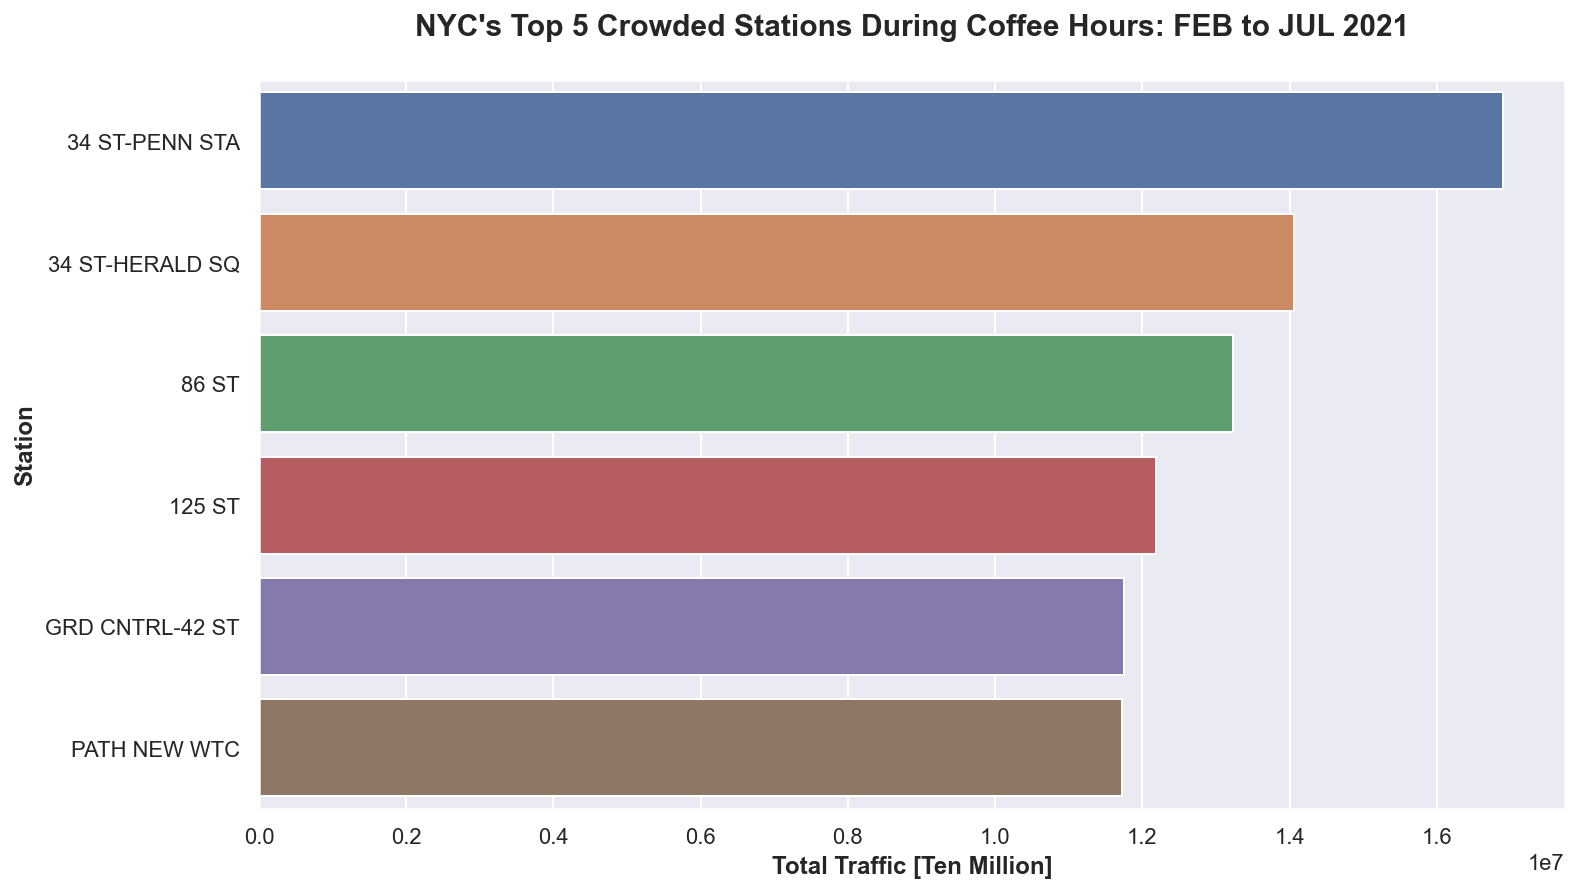

In [41]:
#plotting results of traffic per station
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,6.7)})
ax = sns.barplot(x='TOTAL_TRAFFIC',y ='STATION',data=coffee_station_totals.iloc[:6])\
            .set_title("NYC's Top 5 Crowded Stations During Coffee Hours: FEB to JUL 2021\n",fontsize = 15, weight='bold')
plt.xlabel("Total Traffic [Ten Million]", weight = 'bold')
plt.ylabel("Station", weight = 'bold')
plt.show(ax)

Per figure above, the most crowded stations during coffee hours of Feb-Jul in 2021 are: 
* Penn Station
* Herald Square
* 86 St
* 125 St
* Grand Central and PATH NEW WTC (World Trade Center) (tied!)

Which station has the most train lines?

In [42]:
coffee_hour.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS
DATE_TIME,,,,,,,,,,
2021-07-30 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,17:00:00,5554,590
2021-07-30 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,13:00:00,5554,589
2021-07-30 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/30/2021,09:00:00,5554,589
2021-07-29 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/29/2021,17:00:00,5554,589
2021-07-29 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/29/2021,13:00:00,5554,589


In [43]:
coffee_lines = coffee_hour.groupby('STATION').LINENAME.nunique().sort_values(ascending=False).reset_index(name='LINE_COUNT')
coffee_lines = pd.DataFrame(coffee_lines)
coffee_lines.head()

,STATION,LINE_COUNT
0,86 ST,5
1,23 ST,5
2,125 ST,4
3,28 ST,3
4,CANAL ST,3


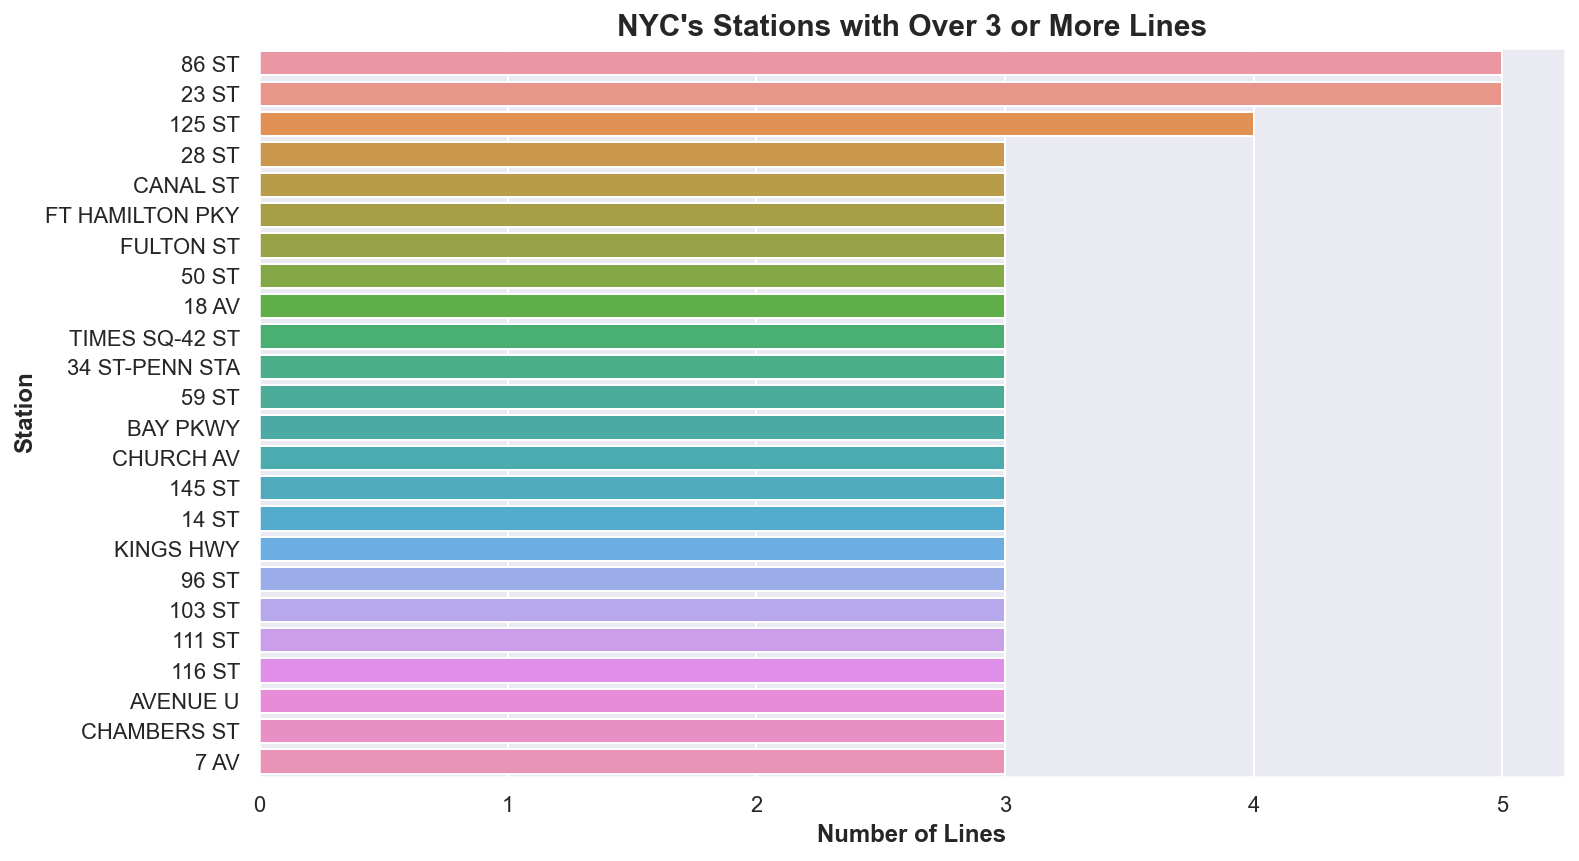

In [44]:
#plotting results of LINE_COUNT per station
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,6.7)})
ax = sns.barplot(x='LINE_COUNT',y ='STATION',data=coffee_lines[coffee_lines['LINE_COUNT'] > 2])\
                    .set_title("NYC's Stations with Over 3 or More Lines",fontsize = 15, weight='bold')
plt.xlabel('Number of Lines', weight = 'bold')
plt.ylabel("Station", weight = 'bold')
plt.show(ax)

Out of top 5 most crowded stations (during coffee hours), 3 stations have appeared in the list! 86 St, 125 St, and Penn Station!

Now let's see which month was crowded the most?!

In [45]:
#creating a dataframe including the month numbers and total traffic for each month
coffee_hour_monthly= coffee_hour_daily.groupby(['MONTH'])[['TOTAL_TRAFFIC']].sum().reset_index()
coffee_hour_monthly.head()

,MONTH,TOTAL_TRAFFIC
0,1,3478903.0
1,2,90264997.0
2,3,110574635.0
3,4,125000168.0
4,5,122623663.0


We want to focus on Feb - Jul time-frame only!

In [46]:
#Let's drop the data for Jan (Month = 1) since it's incomplete!
coffee_hour_monthly.drop(coffee_hour_monthly.loc[coffee_hour_monthly['MONTH']==1].index, inplace=True)
coffee_hour_monthly.head()

,MONTH,TOTAL_TRAFFIC
1,2,90264997.0
2,3,110574635.0
3,4,125000168.0
4,5,122623663.0
5,6,136301748.0


Text(0.5, 1.0, "Monthly Traffic at NYC's Stations During Coffee Hours\n")

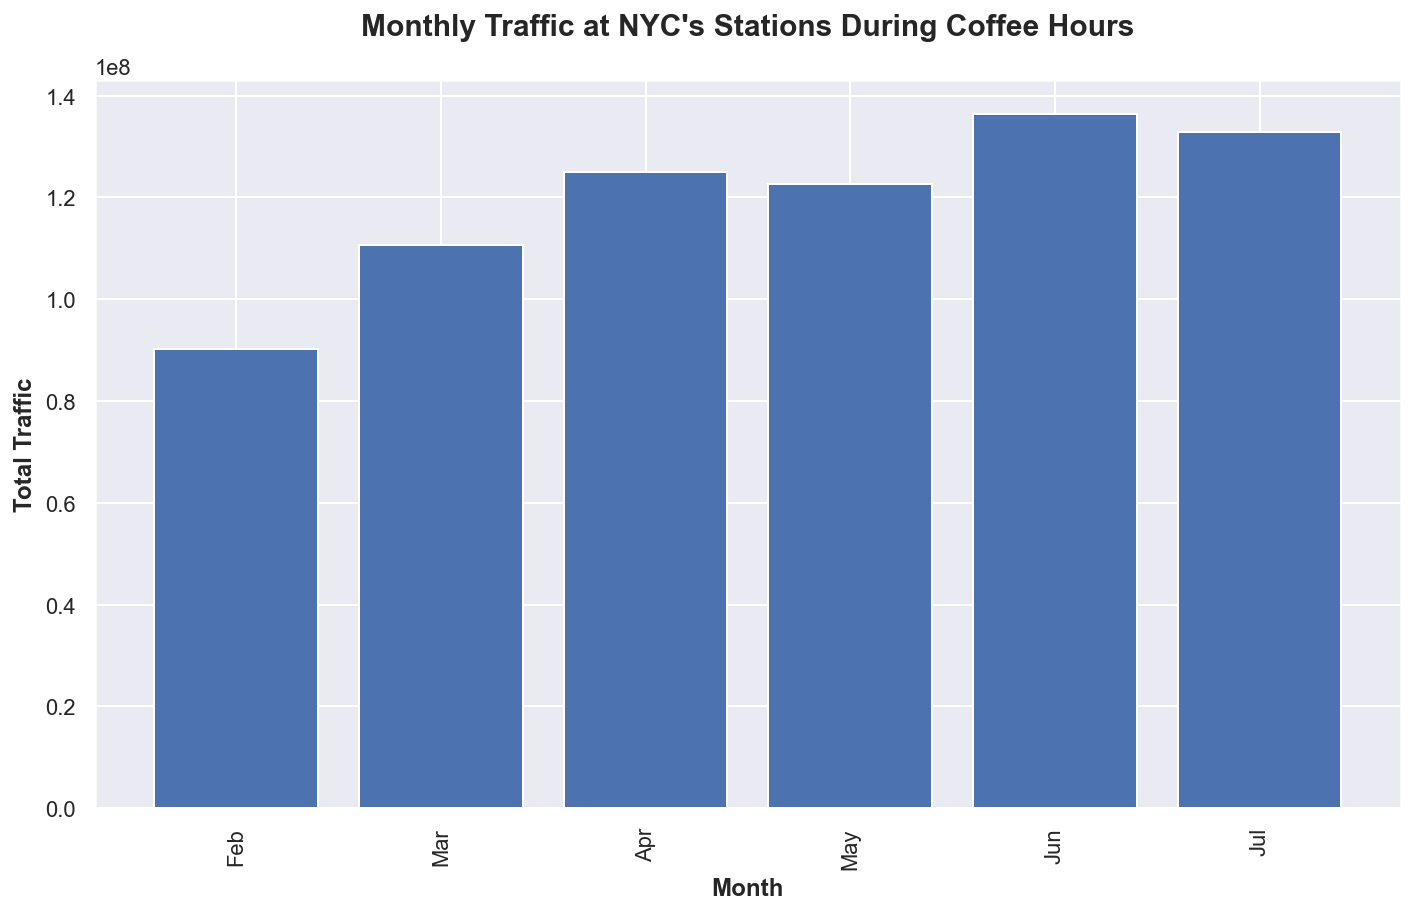

In [47]:
#plotting the monthly traffic during coffee hours
plt.bar(x=coffee_hour_monthly['MONTH'], height=coffee_hour_monthly['TOTAL_TRAFFIC'])
plt.xticks(rotation=90)
plt.xlabel('Month', weight = 'bold')
plt.ylabel('Total Traffic', weight = 'bold')
plt.xticks(coffee_hour_monthly['MONTH'],['Feb','Mar','Apr','May','Jun','Jul'])
plt.title("Monthly Traffic at NYC's Stations During Coffee Hours\n", fontsize = 15, weight = 'bold')

You can see that as NYC's pandemic restrictions are lifted, the commuter traffic in stations have increased!

Let's see how the commuter traffic looks like for the month of July?

In [48]:
#creating a data frame for coffee hours in July
coffee_hour_july =coffee_hour_daily[coffee_hour_daily['MONTH']== 7]
coffee_hour_july= coffee_hour_july.groupby(['STATION','DATE','WEEKDAY','WEEKDAY_INDEX','WEEK_INDEX','MONTH'])\
    .sum().reset_index(.head(7)

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,WEEK_INDEX,MONTH,ENTRIES,EXITS,TOTAL_TRAFFIC
0,1 AV,07/01/2021,Thursday,3,26,7,463409519,467913656,20850.0
1,1 AV,07/02/2021,Friday,4,26,7,463417516,467927424,21765.0
2,1 AV,07/03/2021,Saturday,5,26,7,463424378,467939419,18857.0
3,1 AV,07/04/2021,Sunday,6,26,7,463429931,467949619,15753.0
4,1 AV,07/05/2021,Monday,0,27,7,463437058,467962271,19779.0
5,1 AV,07/06/2021,Tuesday,1,27,7,463443244,467974408,18323.0
6,1 AV,07/07/2021,Wednesday,2,27,7,463450909,467987375,20632.0


<ipython-input-49-09f918804d3a>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.lineplot(data = coffee_hour_july, x='WEEKDAY_INDEX', y='TOTAL_TRAFFIC', color='grey', ax=axs)\


Text(0, 0.5, 'Total Traffic')

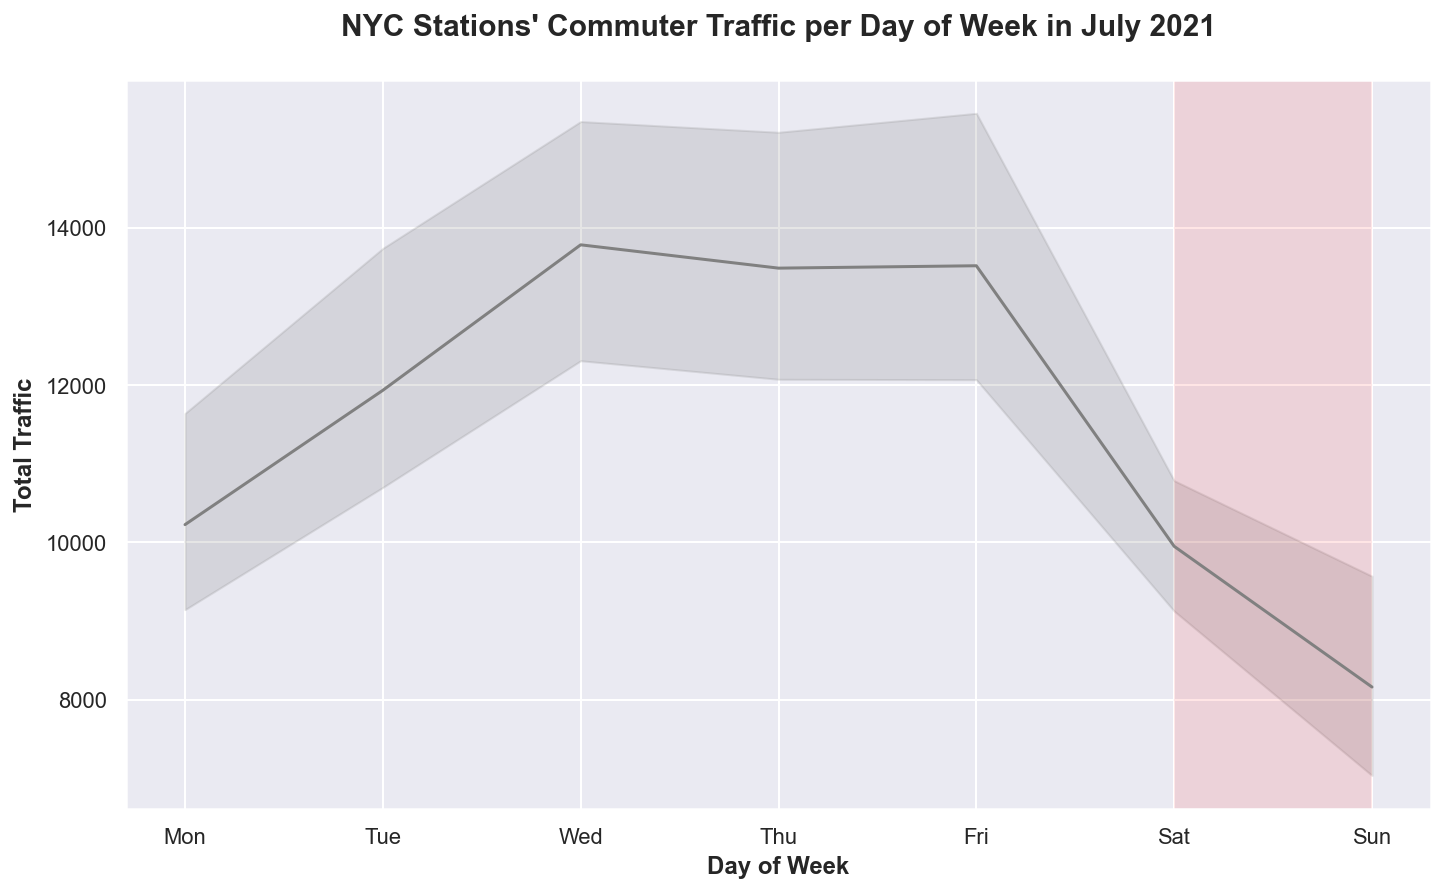

In [49]:
#plotting the commuter traffic during coffee hours in July
fig, axs = plt.subplots(nrows=1)
sns.set(rc={'figure.figsize':(11.7,6.7)})
sns.lineplot(data = coffee_hour_july, x='WEEKDAY_INDEX', y='TOTAL_TRAFFIC', color='grey', ax=axs)\
                        .set(xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
                            
# highlight weekends
axs.axvspan(5, 6, facecolor='red', alpha=.1)
#labels
plt.title("NYC Stations' Commuter Traffic During Coffee Hours per Day of Week in July 2021\n", fontsize = 15, weight = 'bold')
plt.xlabel('Day of Week', weight = 'bold')
plt.ylabel('Total Traffic', weight = 'bold')

 It is obvious that the traffic is much lower during weekends! We can also see traffic peaks on Wednesdays and Fridays!!

In [50]:
#filtering top 6 crowded stations to see how the traffic looks in July
mask = ((coffee_hour_july["STATION"] == "34 ST-PENN STA") |
        (coffee_hour_july["STATION"] == "34 ST-HERALD SQ") |
        (coffee_hour_july["STATION"] == '86 ST')|
        (coffee_hour_july["STATION"] == '125 ST') |
        (coffee_hour_july["STATION"] =='GRD CNTRL-42 ST')|
        (coffee_hour_july["STATION"] =='PATH NEW WTC')) 
coffee_top5station_july= coffee_hour_july[mask]
coffee_top5station_july.head()

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,WEEK_INDEX,MONTH,ENTRIES,EXITS,TOTAL_TRAFFIC
270,125 ST,07/01/2021,Thursday,3,26,7,6733202764,5535492535,64053.0
271,125 ST,07/02/2021,Friday,4,26,7,6733229186,5535527499,62608.0
272,125 ST,07/03/2021,Saturday,5,26,7,6733250627,5535556411,51435.0
273,125 ST,07/04/2021,Sunday,6,26,7,6733268356,5535580533,42835.0
274,125 ST,07/05/2021,Monday,0,27,7,6733286796,5535606742,45599.0


<ipython-input-56-def31ed9558d>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='34 ST-PENN STA'],


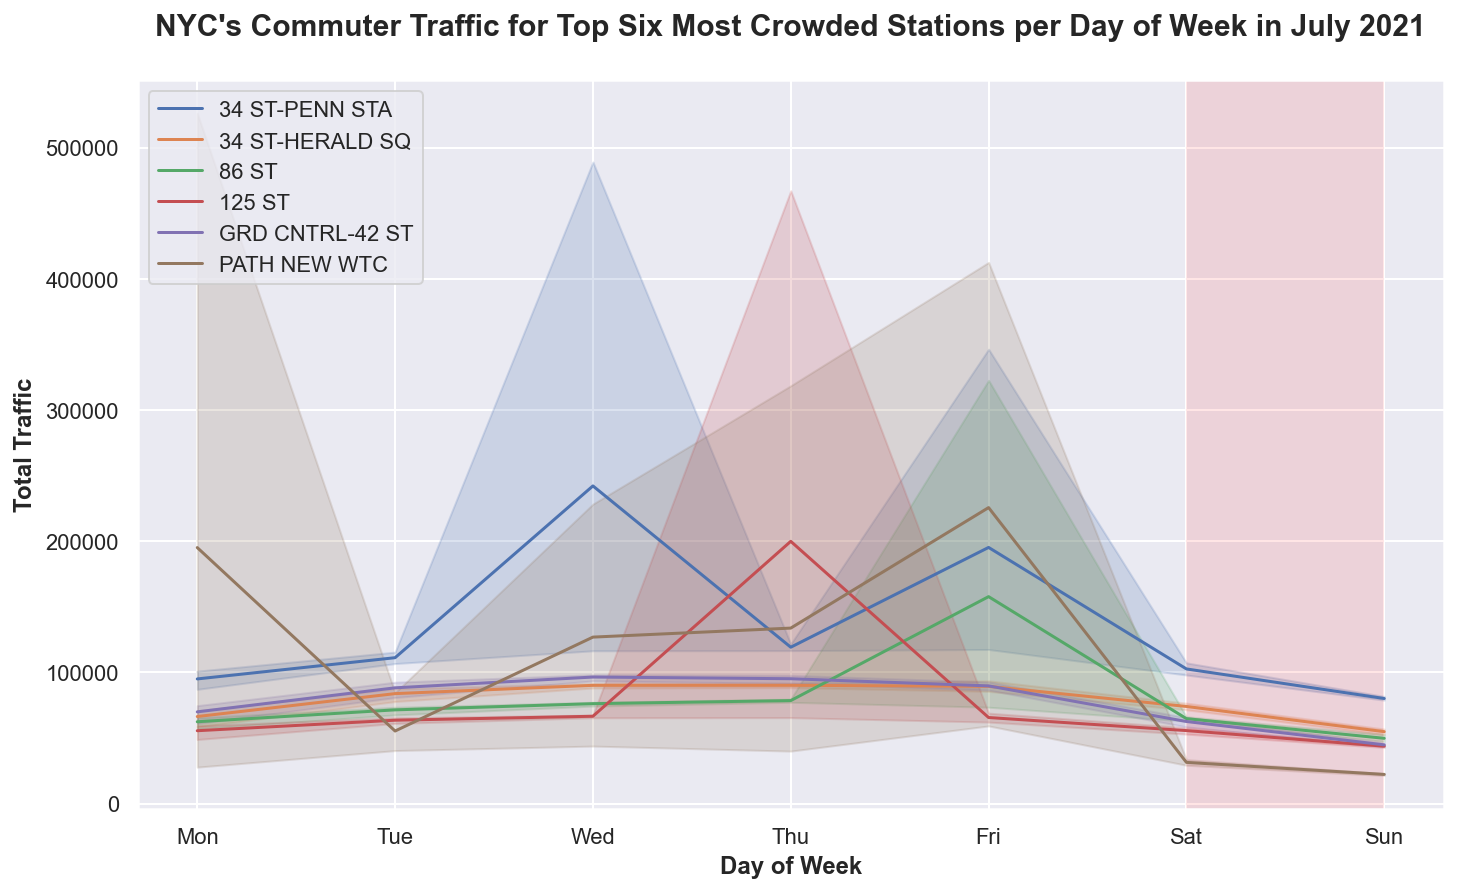

In [56]:
#plotting the top 6 most crowded stations during coffee hours (focusing on July)
fig, axs = plt.subplots(nrows=1)
sns.set(rc={'figure.figsize':(11.7,6.7)})
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='34 ST-PENN STA'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = "34 ST-PENN STA", ax=axs)\
                        .set(xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='34 ST-HERALD SQ'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = "34 ST-HERALD SQ", ax=axs)
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='86 ST'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = "86 ST", ax=axs)
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='125 ST'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = '125 ST', ax=axs)
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='GRD CNTRL-42 ST'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = 'GRD CNTRL-42 ST', ax=axs)
sns.lineplot(data = coffee_top5station_july[ coffee_top5station_july['STATION']=='PATH NEW WTC'],
             x='WEEKDAY_INDEX', 
             y='TOTAL_TRAFFIC', label = 'PATH NEW WTC', ax=axs)

                                                                        
# highlight weekends
axs.axvspan(5, 6, facecolor='red', alpha=.1)
#labels
plt.title("NYC's FEB to JUL 2021 Top 5 Crowded Stations During Coffee Hours: July\n", fontsize = 15, weight = 'bold')
plt.xlabel('Day of Week', weight = 'bold')
plt.ylabel('Total Traffic', weight = 'bold')
axs.legend()

We can see that the commuter traffic is much lower on weekends! We can also see peaks on different days of week for different stations! For Example, it seems that the 34 St Penn Station is the most crowded on Wednesdays and Fridays When 34 St Herald Sq station is crowded on Mondays and Fridays!

Another observation is that the PATH NEW WTC station seems to have higher commmuter traffic than the 34 St Herald Sq for the month of July!! If you recall the 34 St Herald Sq station was our top two crowded station for the past 6 month! Let's see which stations were the most crowded in July:

In [54]:
coffee_station_july = coffee_hour_july.groupby('STATION').sum()\
                            .sort_values('TOTAL_TRAFFIC', ascending=False).reset_index()
coffee_station_july.head()

,STATION,WEEKDAY_INDEX,WEEK_INDEX,MONTH,ENTRIES,EXITS,TOTAL_TRAFFIC
0,34 ST-PENN STA,91,842,210,142014003009,154925811990,4098487.0
1,PATH NEW WTC,91,842,210,132233069,119175461,3522592.0
2,FULTON ST,91,842,210,95984160681,118827069750,3393314.0
3,14 ST-UNION SQ,91,842,210,8201392071,5873699656,2826250.0
4,86 ST,91,842,210,10584371618,11037666939,2480693.0


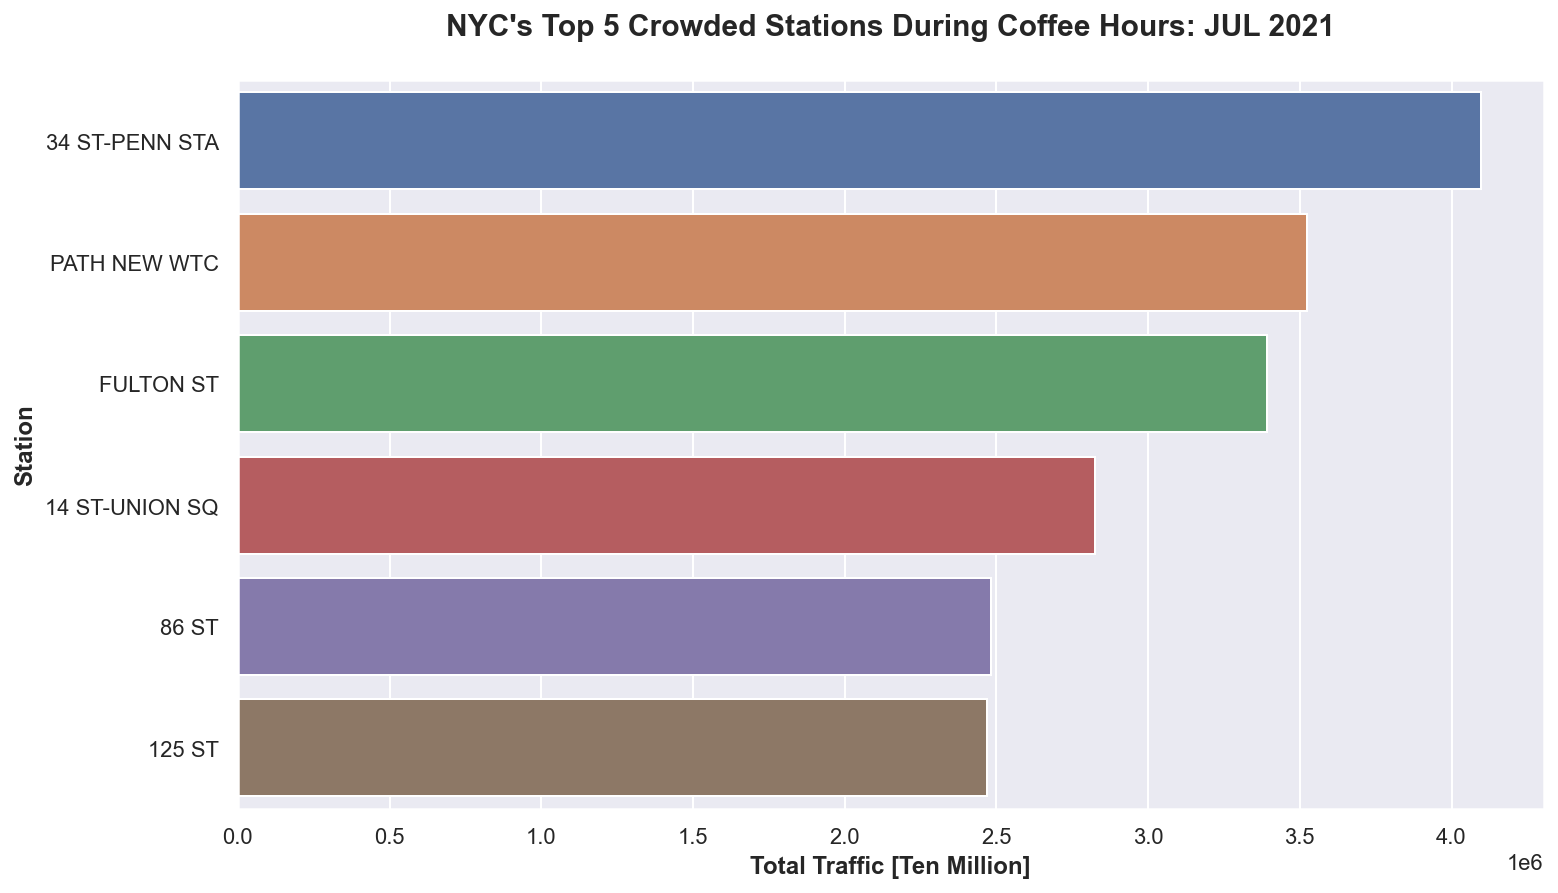

In [55]:
#plotting results of traffic per station in July
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,6.7)})
ax = sns.barplot(x='TOTAL_TRAFFIC',y ='STATION',data=coffee_station_july.iloc[:6])\
            .set_title("NYC's Top 5 Crowded Stations During Coffee Hours: JUL 2021\n",fontsize = 15, weight='bold')
plt.xlabel("Total Traffic [Ten Million]", weight = 'bold')
plt.ylabel("Station", weight = 'bold')
plt.show(ax)

So it seems that there are fluctuations in which stations are the most crowded depending on the month!